In [2]:
!pip install -q transformers datasets

In [3]:
import pandas as pd
from datasets import Dataset

# Load your labeled dataset
df = pd.read_csv("/content/all_labeled.csv")

df.columns

Index(['created_at', 'text', 'is_kecelakaan'], dtype='object')

In [4]:
df_used = df[["text", "is_kecelakaan"]].copy()
# dataset = Dataset.from_pandas(df)

In [5]:
df_used['is_kecelakaan'].value_counts()

,count
is_kecelakaan,
0.0,513
1.0,103


In [6]:
from sklearn.utils import resample

# downsample '0' from is_kecelakaan to match the number of 1
df_used_0 = df_used[df_used['is_kecelakaan'] == 0]
df_used_1 = df_used[df_used['is_kecelakaan'] == 1]

df_used_0_resampled = resample(df_used_0, replace=False, n_samples=len(df_used_1), random_state=42)

# Combine the downsampled
df_used_downsampled = pd.concat([df_used_1, df_used_0_resampled])
assert len(df_used_downsampled) == len(df_used_1)*2
len(df_used_downsampled)


206

In [47]:
from sklearn.model_selection import train_test_split
from datasets import Dataset


train_df, test_df = train_test_split(
    df_used_downsampled,
    test_size=0.2,
    random_state=42        # for reproducibility
)

train_df = train_df.rename(columns={"is_kecelakaan": "label"})
test_df = test_df.rename(columns={"is_kecelakaan": "label"})

train_df['label'] = train_df['label'].astype(int)
test_df['label'] = test_df['label'].astype(int)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [7]:
df["is_kecelakaan"].value_counts()

,count
is_kecelakaan,
0.0,513
1.0,103


In [45]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, problem_type="single_label_classification")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [48]:
def tokenize(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=128)

tokenized_train_dataset = train_dataset.map(tokenize, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize, batched=True)


Map:   0%|          | 0/164 [00:00<?, ? examples/s]

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

In [49]:
!pip install evaluate

In [50]:
from transformers import TrainingArguments, Trainer
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
)

In [51]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
)
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.677600,0.799175,0.476190
2,0.342900,0.583926,0.785714
3,0.304900,0.694069,0.809524
4,0.083900,0.709438,0.857143
5,0.045200,0.718462,0.880952


TrainOutput(global_step=105, training_loss=0.3075937110221102, metrics={'train_runtime': 1798.579, 'train_samples_per_second': 0.456, 'train_steps_per_second': 0.058, 'total_flos': 53939219205120.0, 'train_loss': 0.3075937110221102, 'epoch': 5.0})

In [52]:
trainer.evaluate()

{'eval_loss': 0.5839260816574097,
 'eval_accuracy': 0.7857142857142857,
 'eval_runtime': 16.207,
 'eval_samples_per_second': 2.591,
 'eval_steps_per_second': 0.37,
 'epoch': 5.0}

In [53]:
preds = trainer.predict(test_dataset=tokenized_test_dataset)
y_pred = preds.predictions.argmax(axis=1)
y_true = preds.label_ids


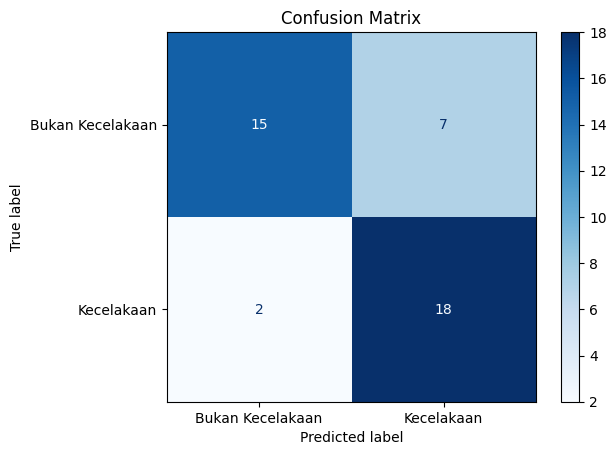

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bukan Kecelakaan", "Kecelakaan"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=["Bukan Kecelakaan", "Kecelakaan"]))


                  precision    recall  f1-score   support

Bukan Kecelakaan       0.88      0.68      0.77        22
      Kecelakaan       0.72      0.90      0.80        20

        accuracy                           0.79        42
       macro avg       0.80      0.79      0.78        42
    weighted avg       0.81      0.79      0.78        42



In [31]:
# save the model to publish
model.save_pretrained("developbyarya/indobert-kecelakaan-post-classifier-v0.1")
tokenizer.save_pretrained("developbyarya/indobert-kecelakaan-post-classifier-v0.1")

('developbyarya/indobert-kecelakaan-post-classifier-v0.1/tokenizer_config.json',
 'developbyarya/indobert-kecelakaan-post-classifier-v0.1/special_tokens_map.json',
 'developbyarya/indobert-kecelakaan-post-classifier-v0.1/vocab.txt',
 'developbyarya/indobert-kecelakaan-post-classifier-v0.1/added_tokens.json',
 'developbyarya/indobert-kecelakaan-post-classifier-v0.1/tokenizer.json')

In [29]:
from huggingface_hub import notebook_login
notebook_login()

In [56]:
model.push_to_hub("developbyarya/indobert-kecelakaan-post-classifier-v0.1")
tokenizer.push_to_hub("developbyarya/indobert-kecelakaan-post-classifier-v0.1")

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/developbyarya/indobert-kecelakaan-post-classifier-v0.1/commit/1a2628b3aadfcf894b929285e9a507bf57675be9', commit_message='Upload tokenizer', commit_description='', oid='1a2628b3aadfcf894b929285e9a507bf57675be9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/developbyarya/indobert-kecelakaan-post-classifier-v0.1', endpoint='https://huggingface.co', repo_type='model', repo_id='developbyarya/indobert-kecelakaan-post-classifier-v0.1'), pr_revision=None, pr_num=None)

In [32]:
df_used_1.to_csv("kecelakaan-only.csv")

In [33]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 16.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [30]:
label2id = {
    "O": 0,
    "B-LOC": 1,
    "I-LOC": 2
}

from transformers import AutoTokenizer
import json

# Load IndoBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Load your file
with open("project-3-at-2025-07-10-13-53-8f4d6601.json") as f:
    data = json.load(f)

dataset = []

for item in data:
    text = item["text"]
    entities = item.get("label", [])

    # Create tag list
    tags = ["O"] * len(text)
    for ent in entities:
        start = ent["start"]
        end = ent["end"]
        if ent["labels"][0] == "LOC":
            tags[start] = "B-LOC"
            for i in range(start + 1, end):
                tags[i] = "I-LOC"

    # Tokenize and align
    tokenized = tokenizer(text, return_offsets_mapping=True, truncation=True, max_length=128)
    tokens = tokenizer.convert_ids_to_tokens(tokenized["input_ids"])
    offsets = tokenized["offset_mapping"]

    aligned_labels = []
    for offset in offsets:
        if offset == (0, 0):  # CLS, SEP
            aligned_labels.append("O")
            continue
        start, end = offset
        if start < len(tags):
            tag = tags[start]
        else:
            tag = "O"
        aligned_labels.append(tag)

    # Remove CLS and SEP
    dataset.append({
        "tokens": tokens[1:-1],
        "ner_tags": [label2id[tag] for tag in aligned_labels[1:-1]]
    })


In [31]:
import json

with open("ner_dataset.json", "w") as f:
    json.dump(dataset, f, indent=2)


In [32]:
label2id = {"O": 0, "B-LOC": 1, "I-LOC": 2}
id2label = {0: "O", 1: "B-LOC", 2: "I-LOC"}

In [35]:
from datasets import Dataset
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
import json

# Load JSON file using standard json library
with open("ner_dataset.json", "r") as f:
    raw_data = json.load(f)

# Convert data to a format suitable for Dataset.from_dict
dataset_dict = {key: [d[key] for d in raw_data] for key in raw_data[0]}
dataset = Dataset.from_dict(dataset_dict)


# Split
train_test = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test['train']
test_dataset = train_test['test']

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Align tokens and labels
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], is_split_into_words=True, truncation=True)
    word_ids = tokenized_inputs.word_ids()

    previous_word_idx = None
    label_ids = []
    for word_idx in word_ids:
        if word_idx is None:
            label_ids.append(-100)
        elif word_idx != previous_word_idx:
            label_ids.append(example["ner_tags"][word_idx])
        else:
            # For subwords: use the same label or I-XXX
            label_ids.append(example["ner_tags"][word_idx] if example["ner_tags"][word_idx] != 0 else 0)
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = label_ids
    return tokenized_inputs

tokenized_train = train_dataset.map(tokenize_and_align_labels, batched=False)
tokenized_test = test_dataset.map(tokenize_and_align_labels, batched=False)

Map:   0%|          | 0/82 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/21 [00:00<?, ? examples/s]

In [36]:
from transformers import AutoModelForTokenClassification

model = AutoModelForTokenClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=3,
    id2label={0: "O", 1: "B-LOC", 2: "I-LOC"},
    label2id={"O": 0, "B-LOC": 1, "I-LOC": 2}
)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=d6a280d80579651ad9a5c8bb99b5375fa998477020cbe5e493c5cd9c9b42dcdf
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [39]:
from transformers import TrainingArguments, Trainer, DataCollatorForTokenClassification
import evaluate
import numpy as np

seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    return seqeval.compute(predictions=true_predictions, references=true_labels)

args = TrainingArguments(
    output_dir="./ner_results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=DataCollatorForTokenClassification(tokenizer),
    compute_metrics=compute_metrics,
)


/tmp/ipython-input-39-4000066694.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [40]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: developbyarya (developbyarya-upn-veteran-yogyakarta) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Loc,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.429100,0.226783,"{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 30}",0.000000,0.000000,0.000000,0.923377
2,0.168000,0.129321,"{'precision': 0.15625, 'recall': 0.16666666666666666, 'f1': 0.16129032258064516, 'number': 30}",0.156250,0.166667,0.161290,0.956076
3,0.088300,0.113289,"{'precision': 0.21212121212121213, 'recall': 0.23333333333333334, 'f1': 0.22222222222222224, 'number': 30}",0.212121,0.233333,0.222222,0.960469
4,0.080400,0.138423,"{'precision': 0.1935483870967742, 'recall': 0.2, 'f1': 0.19672131147540983, 'number': 30}",0.193548,0.200000,0.196721,0.953636
5,0.049600,0.115019,"{'precision': 0.25, 'recall': 0.26666666666666666, 'f1': 0.2580645161290323, 'number': 30}",0.250000,0.266667,0.258065,0.959980


Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 30}" of type <class 'dict'> for key "eval/LOC" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.15625, 'recall': 0.16666666666666666, 'f1': 0.16129032258064516, 'number': 30}" of type <class 'dict'> for key "eval/LOC" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.21212121212121213, 'recall': 0.23333333333333334, 'f1': 0.22222222222222224, 'number': 30}" of type <class 'dict'> for key "eval/LOC" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.1935483870967742, 'recall': 0.2, 'f1': 0.19672131147540983, 'number': 30}" of type <class 'dict'> for k

TrainOutput(global_step=55, training_loss=0.15258394154635344, metrics={'train_runtime': 863.4416, 'train_samples_per_second': 0.475, 'train_steps_per_second': 0.064, 'total_flos': 32916544109316.0, 'train_loss': 0.15258394154635344, 'epoch': 5.0})

In [41]:
trainer.evaluate()

Trainer is attempting to log a value of "{'precision': 0.25, 'recall': 0.26666666666666666, 'f1': 0.2580645161290323, 'number': 30}" of type <class 'dict'> for key "eval/LOC" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.11501876264810562,
 'eval_LOC': {'precision': 0.25,
  'recall': 0.26666666666666666,
  'f1': 0.2580645161290323,
  'number': 30},
 'eval_overall_precision': 0.25,
 'eval_overall_recall': 0.26666666666666666,
 'eval_overall_f1': 0.2580645161290323,
 'eval_overall_accuracy': 0.9599804782820889,
 'eval_runtime': 21.2812,
 'eval_samples_per_second': 0.987,
 'eval_steps_per_second': 0.141,
 'epoch': 5.0}

In [42]:
trainer.save_model("indobert-ner-loc")
tokenizer.save_pretrained("indobert-ner-loc")

('indobert-ner-loc/tokenizer_config.json',
 'indobert-ner-loc/special_tokens_map.json',
 'indobert-ner-loc/vocab.txt',
 'indobert-ner-loc/added_tokens.json',
 'indobert-ner-loc/tokenizer.json')

In [43]:
from huggingface_hub import notebook_login
notebook_login()

In [44]:
model.push_to_hub("developbyarya/indobert-ner-loc")
tokenizer.push_to_hub("developbyarya/indobert-ner-loc")

model.safetensors:   0%|          | 0.00/495M [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

CommitInfo(commit_url='https://huggingface.co/developbyarya/indobert-ner-loc/commit/9659699205355d35e416a3e745962d62ee853d62', commit_message='Upload tokenizer', commit_description='', oid='9659699205355d35e416a3e745962d62ee853d62', pr_url=None, repo_url=RepoUrl('https://huggingface.co/developbyarya/indobert-ner-loc', endpoint='https://huggingface.co', repo_type='model', repo_id='developbyarya/indobert-ner-loc'), pr_revision=None, pr_num=None)